## Library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from string import digits

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
import transformers
from transformers import TFAutoModel
from tokenizers import BertWordPieceTokenizer
from transformers import AutoTokenizer
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

trainable_mode = "distilbert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(trainable_mode)
tokenizer = transformers.DistilBertTokenizer.from_pretrained(trainable_mode, lower = True)

2024-11-13 21:10:56.196235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-13 21:10:56.452601: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 21:10:56.523879: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 21:11:01.113641: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load Data

In [3]:
df = pd.read_csv("Data/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


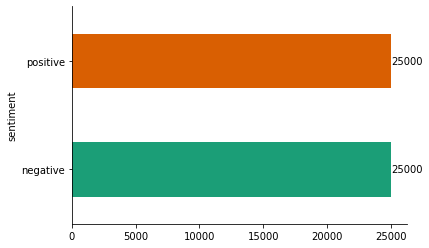

In [4]:
df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
for index, value in enumerate(df.groupby('sentiment').size()):
    plt.text(value, index, str(value), va='center')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Pre-Processing

### Drop Duplicate

In [5]:
df = df.drop_duplicates(subset = ['review'], keep = 'first')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


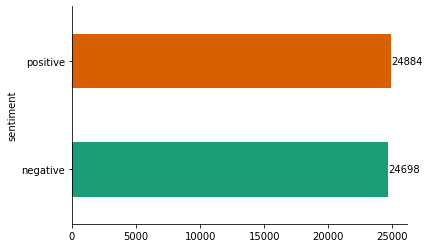

In [6]:
df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
for index, value in enumerate(df.groupby('sentiment').size()):
    plt.text(value, index, str(value), va='center')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Remove Symbol or Other

In [7]:
def clean_text(text):
    ReSymbol = re.sub(r'[^\w]', ' ', text)
    Re_Char = re.sub(r'\b\w{2,3}\b', '', ReSymbol)
    Re_Space = re.sub(r' +', ' ', Re_Char)
    Re_Digits = str.maketrans('', '', digits) 
    ReNumber = Re_Space.translate(Re_Digits)
    Result = ReNumber.strip()
    return Result

In [8]:
df['cleaned_review'] = df['review'].apply(clean_text)

In [9]:
df.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,other reviewers mentioned that after watching ...
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production filming techniqu...
2,I thought this was a wonderful way to spend ti...,positive,I thought this a wonderful spend time a summer...
3,Basically there's a family where a little boy ...,negative,Basically there s a family where a little Jake...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,Petter Mattei s Love Time Money a visually stu...


## Label Encodding

In [10]:
label_encoder = preprocessing.LabelEncoder()
df['sentiment_encodding']= label_encoder.fit_transform(df['sentiment']) 

In [11]:
df.head(10)

,review,sentiment,cleaned_review,sentiment_encodding
0,One of the other reviewers has mentioned that ...,positive,other reviewers mentioned that after watching ...,1
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production filming techniqu...,1
2,I thought this was a wonderful way to spend ti...,positive,I thought this a wonderful spend time a summer...,1
3,Basically there's a family where a little boy ...,negative,Basically there s a family where a little Jake...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,Petter Mattei s Love Time Money a visually stu...,1
5,"Probably my all-time favorite movie, a story o...",positive,Probably time favorite movie a story selflessn...,1
6,I sure would like to see a resurrection of a u...,positive,I sure would like a resurrection a dated Seahu...,1
7,"This show was an amazing, fresh & innovative i...",negative,This show amazing fresh innovative idea s when...,0
8,Encouraged by the positive comments about this...,negative,Encouraged positive comments about this film h...,0
9,If you like original gut wrenching laughter yo...,positive,like original wrenching laughter will like thi...,1


## EDA

### Search MAX_LEN

/tmp/ipykernel_4369/3255519789.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seqlen_plot = sns.distplot(seqlen)


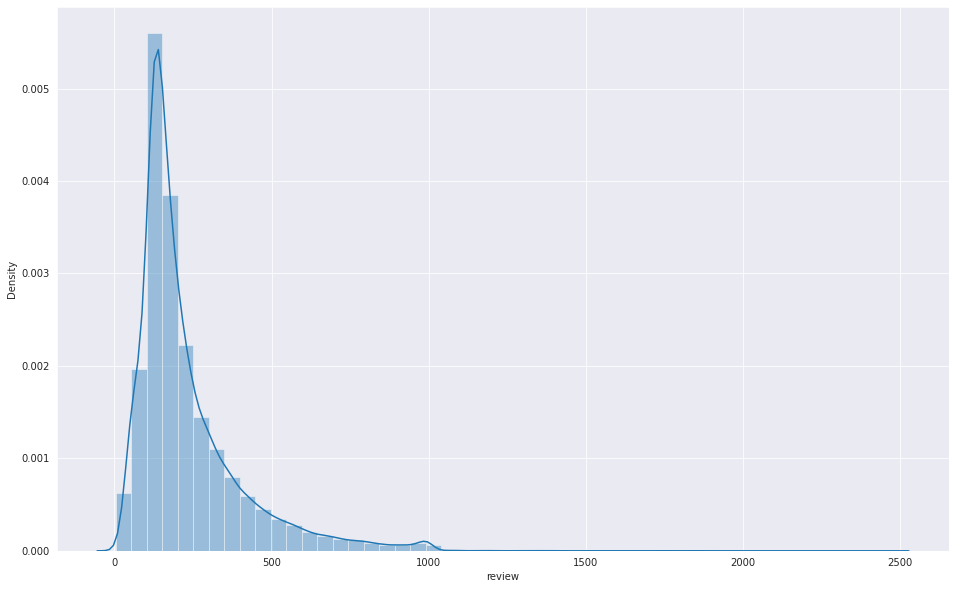

In [12]:
seqlen = df['review'].apply(lambda x: len(x.split()))
sns.set_style('darkgrid')
plt.figure(figsize = (16, 10))
seqlen_plot = sns.distplot(seqlen)

fig = seqlen_plot.get_figure()
fig.savefig("seqlen_plot.png")

## Tokenizer & Data Split

In [13]:
MAX_LEN = 512 # 512 Itu From Picture Search Max_Len

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(df.cleaned_review, df.sentiment_encodding, 
                                                      random_state =42, 
                                                      test_size=0.2,
                                                      stratify = df.sentiment_encodding)

In [15]:
# tokenizer.save_pretrained('.')
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [16]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [17]:
x_train = fast_encode(x_train.values, fast_tokenizer, maxlen=512)
x_valid = fast_encode(x_valid.values, fast_tokenizer, maxlen=512)

## Model Train

In [18]:
def build_model(transformer, max_len=MAX_LEN):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [19]:
bert_model = transformers.TFDistilBertModel.from_pretrained(trainable_mode)
model = build_model(bert_model, max_len=MAX_LEN)
model.summary()

/home/cdsw/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-11-13 21:12:08.099322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-13 21:12:08.340984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDis

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 512)]            0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 512,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                             

/home/cdsw/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'bert_imdb.h5', monitor='val_accuracy', save_best_only=True, mode='max'
)

In [21]:
history = model.fit(x_train, y_train, batch_size=32, validation_data=(x_valid, y_valid), epochs=3, callbacks=[model_checkpoint])

Epoch 1/3
1240/1240 [==============================] - 938s 739ms/step - loss: 0.2951 - accuracy: 0.8700 - val_loss: 0.2826 - val_accuracy: 0.8886
Epoch 2/3
1240/1240 [==============================] - 913s 736ms/step - loss: 0.1797 - accuracy: 0.9309 - val_loss: 0.2071 - val_accuracy: 0.9205
Epoch 3/3
1240/1240 [==============================] - 881s 710ms/step - loss: 0.1048 - accuracy: 0.9623 - val_loss: 0.2297 - val_accuracy: 0.9190


## Result with Visual

In [29]:
# print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test, y_test)[1]*100 , "%")

In [30]:
# train_loss, train_accuracy = model.evaluate((x_train, y_train))
# print("train_loss: ", train_loss)
# print("train_accuracy: ", train_accuracy)

In [ ]:
# val_loss, val_accuracy = model.evaluate((x_valid, y_valid))
# print("val_loss: ", val_loss)
# print("val_accuracy: ", val_accuracy)

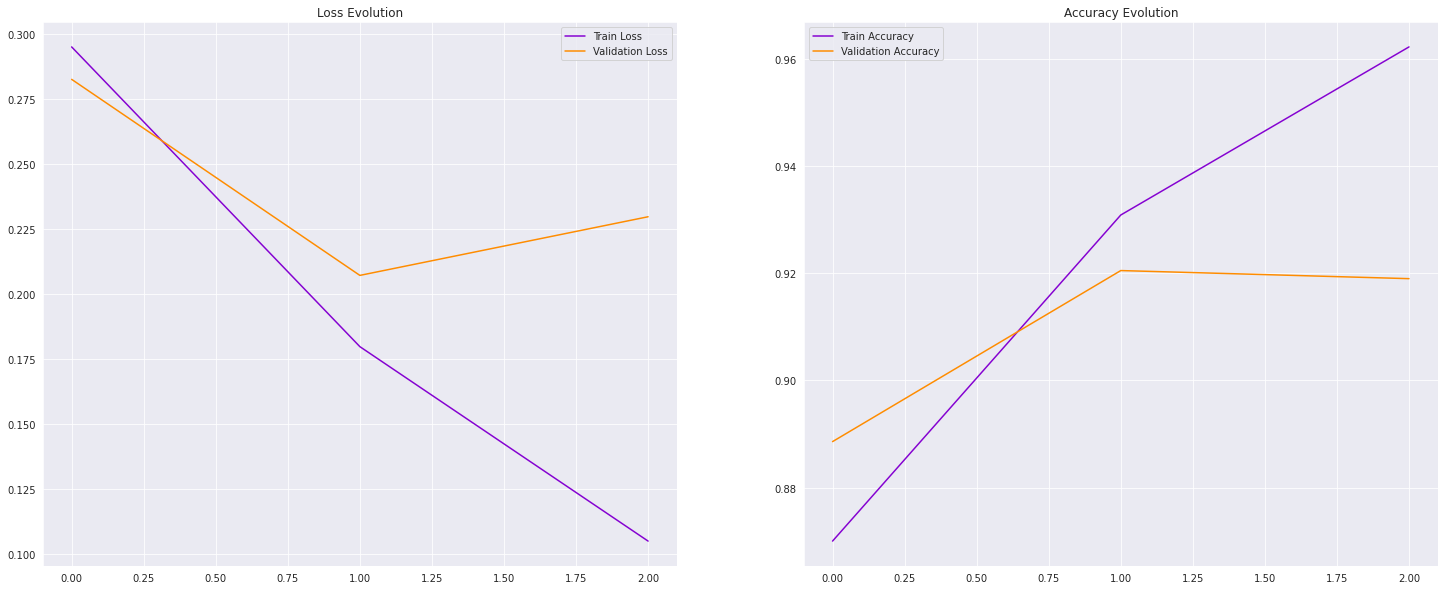

In [28]:
plt.figure(figsize=(25,10))

# training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

## Run Model with Test Set

In [33]:
data_test = pd.read_excel("Data_Test_IMDB.xlsx")
data_test.head()

,review,sentiment
0,Amazing storyline and fantastic acting! Truly ...,Positive
1,"Boring and slow-paced, didn't enjoy it at all.",Negative
2,Beautiful visuals and a moving plot. Highly re...,Positive
3,Poorly written and predictable.,Negative
4,"Absolutely loved it, one of the best movies I'...",Positive


In [34]:
data_test['cleaned_review'] = data_test['review'].apply(clean_text)
data_test['sentiment_encodding']= label_encoder.fit_transform(data_test['sentiment']) 
data_test.head()

,review,sentiment,cleaned_review,sentiment_encodding
0,Amazing storyline and fantastic acting! Truly ...,Positive,Amazing storyline fantastic acting Truly a mus...,1
1,"Boring and slow-paced, didn't enjoy it at all.",Negative,Boring slow paced didn t enjoy,0
2,Beautiful visuals and a moving plot. Highly re...,Positive,Beautiful visuals a moving plot Highly recommend,1
3,Poorly written and predictable.,Negative,Poorly written predictable,0
4,"Absolutely loved it, one of the best movies I'...",Positive,Absolutely loved best movies I seen this year,1


In [35]:
x_test = fast_encode(data_test.cleaned_review, fast_tokenizer, maxlen=512)

In [46]:
y_pred = model.predict(x_test)

2/2 [==============================] - 1s 305ms/step


In [48]:
y_pred = np.round(y_pred).astype(int)
y_pred

array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

In [49]:
y_test = data_test.sentiment_encodding
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



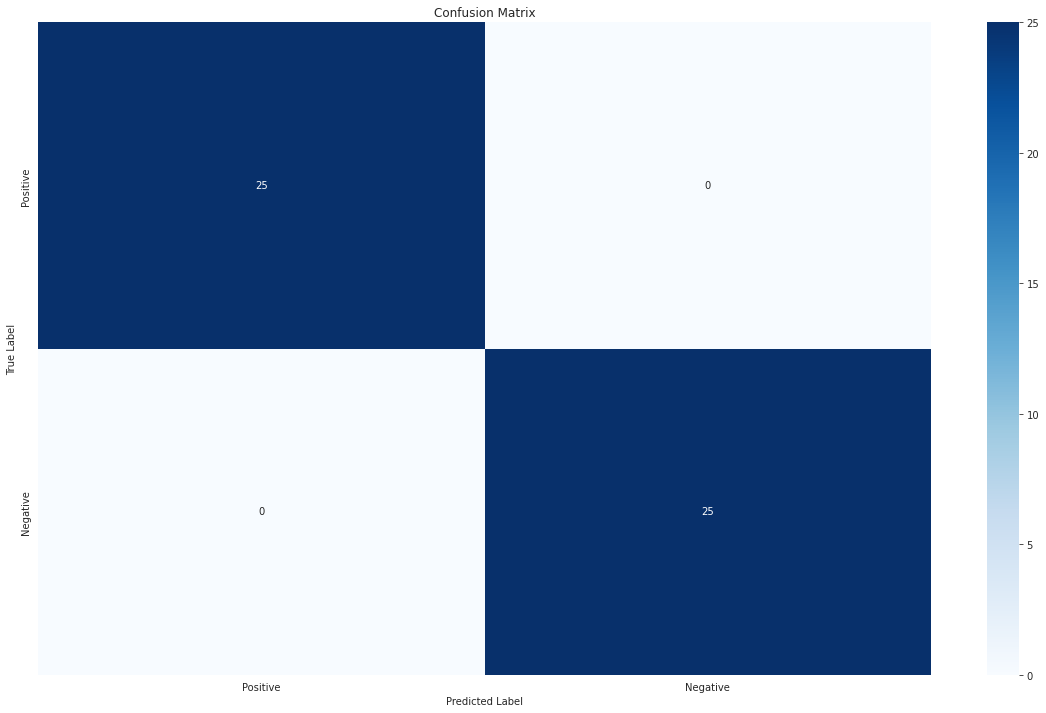

In [50]:
labels = ['Positive', 'Negative']

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, 
            yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()